In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time
import math
from numba import njit,prange

In [4]:
@njit(boundscheck=True)
def Strap(Vrf, Vdc):
    
    #Define the parameters that make up your trap
    eps = 0.97413; #roughly the eccentricity
    a = 0.05; #semi-minor axis
    c = 0.3*a; #distance from center to pole, semi major #0.293 is the exact like his photo, but doesn't give as good of a trap
    Rmin = c; #radius of the waist of the ellipsoid
    R = 0.012;
    m = 0.005; #additional mirror thickness horizontal
    t =  0.03; # the very top of the mirror
    s = -0.04995;#-0.025; # the bottom of the grounded part/the top of the RF part
    u = -0.046965; # where the top of the laser opening is
    d = -0.048465; # where the bottom of the laser opening is
    u0 = 0.5*(u + d); # The z point of the optical focus (0, 0 , u0)
    slope = 0.5; #slope of line of laser slits
    b = -0.0509; # The bottom of the mirror block
    Rhole = 0.00076; #radius of the hole
    RholeLaser = 0.001; # Radius of the laser hole
    Hoffset = -0.0472; #offset of the hole in the x direction
    COuterR = 0.000105; # The outer radius of the central grounded electrode
    CInnerR = 0.00005; # The inner radius of the central grounded electrode
    CHeight = 0.002; # The half height of the central grounded electrode
    RFOuterR = 0.000455;#0.000675; # The outer radius of the RF electrode
    RFInnerR = 0.0003;#0.000375; # The inner radius of the RF electrode
    RFHeight = 0.0015;#0.00085; # The half height of the RF electrode
    RodR = 0.000075; # Radius of the correction rods
    RodHeight = 0.0007; # Height of the correction rods
    offset = 0.0005; # x and y offset of the correction rods
    
    Hneedle = 0.00018;#0.0013; #height of needle inside trap up until the beginning of the needle tip
    Rneedle = .00023;#0.00023; #radius of needle
    HneedleTip = 0.0035; # height of needle tip from needle body
    RneedleTip = 0.00002; # the ball at the top of the needle to avoid fringing effects
    Nslope = 3.1; # slope of the needle 
    

    # Picking the size of our world
    gmax = 0.052 #physical size of the space simulated (meters)
    points = 801 # number of points that are being simulated
    steps = points - 1 # just the number of points minus one
    x = np.linspace(-gmax/2, gmax/2, points) #chosing how much space in the x, y, z direction, where it begins and where it ends
    y = np.linspace(-gmax/2, gmax/2, points)
    z = np.linspace(-gmax, 0, points)
    size = len(x)
    sizeZ = len(z)
    xmid = int((size)/2)
    ymid = int((size)/2)
    zmid = int((sizeZ)/2) 
    lattice_points=np.zeros((size**3,3))
    marker=0
    
    V0 = np.zeros((size, size, size)) #initialize the matrix for electric potential
    V0dc= np.zeros((size, size, size))
    V0_temp=np.zeros((size, size, size))
    V0dc_temp=np.zeros((size, size, size))
    cords=np.zeros((size, size, size, 3))
    iterations = 500 #number of iterations
    CenterV = np.zeros((iterations,1)) #keep track of the potential value at the center at each iteration
    
     # Now define the boundry conditions
    for i in range(len(x)):
        for j in range(len(y)):
            for k in range(len(z)):
                cords[i, j, k] = [i, j, k]
                
                 #The ellipsoidal mirror part 1, the laser slit and up
                #if ((z[k] > (a/c)* np.sqrt(c**2 - x[i]**2 -y[j]**2)) and (z[k] < t) and (z[k] > slope*x[i] + u) and (z[k] > s)): #the top half of the ellipsoid
                #    V0[i, j, k] = Vrf[0]
                #    V0dc[i, j, k] = Vdc[0]
                #elif ((z[k] < -(a/c)* np.sqrt(c**2 - x[i]**2 -y[j]**2)) and (z[k] < t) and (z[k] > slope*x[i] + u) and (z[k] > s)): #the bottom half of the ellipsoid
                #    V0[i, j, k] = Vrf[0]
                #    V0dc[i, j, k] = Vdc[0]
                #elif ((y[j] > np.sqrt(Rmin**2 - x[i]**2)) and (y[j] < Rmin + m) and (z[k] < t) and (z[k] > slope*x[i] + u) and (z[k] > s)): #other part of mirror going around the top of ellipsoid
                #    V0[i, j, k] = Vrf[0]
                #    V0dc[i, j, k] = Vdc[0]
                #elif ((y[j] < -np.sqrt(Rmin**2 - x[i]**2)) and (y[j] > -Rmin - m) and (z[k] < t) and (z[k] > slope*x[i] + u) and (z[k] > s)):#other part of mirror going around the bottom of ellipsoid
                #    V0[i, j, k] = Vrf[0]
                #    V0dc[i, j, k] = Vdc[0]
                #elif ((x[i] < Rmin + m) and (x[i] > Rmin) and (y[j] < Rmin + m) and (y[j] > -Rmin - m) and (z[k] < t ) and (z[k] > slope*x[i] + u) and (z[k] > s)): # to make an even square around ellipsoid
                #    V0[i, j, k] = Vrf[0]
                #    V0dc[i, j, k] = Vdc[0]
                #elif ((x[i] < - Rmin) and (x[i] > -Rmin - m) and (y[j] < Rmin + m) and (y[j] > -Rmin - m) and (z[k] < t) and (z[k] > slope*x[i] + u) and (z[k] > s)): # to make an even square around ellipsoid
                #    V0[i, j, k] = Vrf[0]
                #    V0dc[i, j, k] = Vdc[0]
                    
                #The ellipsoidal mirror part 2, the laser slit and down
                #elif ((z[k] > (a/c)* np.sqrt(c**2 - x[i]**2 -y[j]**2)) and (z[k] < slope*x[i] + d) and (z[k] > s) and (z[k] < t)): #the top half of the ellipsoid
                #    V0[i, j, k] = Vrf[0]
                #    V0dc[i, j, k] = Vdc[0]
                #elif ((z[k] < -(a/c)* np.sqrt(c**2 - x[i]**2 -y[j]**2)) and (z[k] < slope*x[i] + d) and (z[k] > s) and (z[k] < t)): #the bottom half of the ellipsoid
                #    V0[i, j, k] = Vrf[0]
                #    V0dc[i, j, k] = Vdc[0]
                #elif ((y[j] > np.sqrt(Rmin**2 - x[i]**2)) and (y[j] < Rmin + m) and (z[k] < slope*x[i] + d) and (z[k] > s) and (z[k] < t)): #other part of mirror going around the top of ellipsoid
                #    V0[i, j, k] = Vrf[0]
                #    V0dc[i, j, k] = Vdc[0]
                #elif ((y[j] < -np.sqrt(Rmin**2 - x[i]**2)) and (y[j] > -Rmin - m) and (z[k] < slope*x[i] + d) and (z[k] > s) and (z[k] < t)):#other part of mirror going around the bottom of ellipsoid
                #    V0[i, j, k] = Vrf[0]
                #    V0dc[i, j, k] = Vdc[0]
                #elif ((x[i] < Rmin + m) and (x[i] > Rmin) and (y[j] < Rmin + m) and (y[j] > -Rmin - m) and (z[k] < slope*x[i] + d) and (z[k] > s) and (z[k] < t)): # to make an even square around ellipsoid
                #    V0[i, j, k] = Vrf[0]
                #    V0dc[i, j, k] = Vdc[0]
                #elif ((x[i] < - Rmin) and (x[i] > -Rmin - m) and (y[j] < Rmin + m) and (y[j] > -Rmin - m) and (z[k] < slope*x[i] + d) and (z[k] > s) and (z[k] < t)): # to make an even square around ellipsoid
                #    V0[i, j, k] = Vrf[0]
                #    V0dc[i, j, k] = Vdc[0]
                    
                # Bottom of the ellipsoidal mirror part 1, the laser slit and up
                #elif ((x[i] > np.sqrt(Rhole**2 - y[j]**2)) and (x[i] < Rmin + m) and (y[j] < Rmin + m) and (y[j] > -Rmin - m) and (z[k] <= s) and (z[k] > b)):
                #    V0[i, j, k] = Vrf[0]
                #    V0dc[i, j, k] = Vdc[0]
                #elif ((x[i] < -np.sqrt(Rhole**2 - y[j]**2)) and (x[i] > -Rmin - m) and (y[j] < Rmin + m) and (y[j] > -Rmin - m) and (z[k] <= s) and (z[k] > b)): # and (z[k] > slope*x[i] + u)):
                #    V0[i, j, k] = Vrf[0]
                #    V0dc[i, j, k] = Vdc[0]
                #elif ((x[i] > -Rmin - m) and (y[j] < -Rhole) and (x[i] < Rmin + m) and (y[j] > -Rmin - m) and (z[k] <= s) and (z[k] > b)):
                #    V0[i, j, k] = Vrf[0]
                #    V0dc[i, j, k] = Vdc[0]
                #elif ((x[i] < Rmin + m) and (y[j] > Rhole) and (y[j] < Rmin + m) and (x[i] > -Rmin - m) and (z[k] <= s) and (z[k] > b)):
                #    V0[i, j, k] = Vrf[0]
                #    V0dc[i, j, k] = Vdc[0]
                    
                # Bottom of the ellipsoidal mirror part 2, the laser slit and down
                #elif ((x[i] > np.sqrt(Rhole**2 - y[j]**2)) and (x[i] < Rmin + m) and (y[j] < Rmin + m) and (y[j] > -Rmin - m) and (z[k] <= s) and (z[k] > b)):
                #    V0[i, j, k] = Vrf[0]
                #    V0dc[i, j, k] = Vdc[0]
                #elif ((x[i] < -np.sqrt(Rhole**2 - y[j]**2)) and (x[i] > -Rmin - m) and (y[j] < Rmin + m) and (y[j] > -Rmin - m) and (z[k] <= s) and (z[k] > b)):# and (z[k] < slope*x[i] + d)):
                #    V0[i, j, k] = Vrf[0]
                #    V0dc[i, j, k] = Vdc[0]
                #elif ((x[i] > -Rmin - m) and (y[j] < -Rhole) and (x[i] < Rmin + m) and (y[j] > -Rmin - m) and (z[k] <= s) and (z[k] > b)):
                #    V0[i, j, k] = Vrf[0]
                #    V0dc[i, j, k] = Vdc[0]
                #elif ((x[i] < Rmin + m) and (y[j] > Rhole) and (y[j] < Rmin + m) and (x[i] > -Rmin - m) and (z[k] <= s) and (z[k] > b)):
                #    V0[i, j, k] = Vrf[0]
                #    V0dc[i, j, k] = Vdc[0]
                    
                # The RF cylinder
                if ((x[i] < np.sqrt(RFOuterR**2 - y[j]**2)) and (x[i] > np.sqrt(RFInnerR**2 - y[j]**2)) and (z[k] > -RFHeight + s) and (z[k] < RFHeight + s) and (z[k]  <  -np.sqrt(x[i]**2 + y[j]**2)* Nslope + s + CHeight)):
                    V0[i, j, k] = Vrf[1]
                    V0dc[i, j, k] = Vdc[1]
                elif ((x[i] > -np.sqrt(RFOuterR**2 - y[j]**2)) and (x[i] < -np.sqrt(RFInnerR**2 - y[j]**2)) and (z[k] > -RFHeight + s) and (z[k] < RFHeight + s) and (z[k]  <  -np.sqrt(x[i]**2 + y[j]**2)* Nslope + s + CHeight)):
                    V0[i, j, k] = Vrf[1]
                    V0dc[i, j, k] = Vdc[1]
                elif ((y[j] > -np.sqrt(RFOuterR**2 - x[i]**2)) and (y[j] < -np.sqrt(RFInnerR**2 - x[i]**2)) and (z[k] > -RFHeight + s) and (z[k] < RFHeight + s) and (z[k]  <  -np.sqrt(x[i]**2 + y[j]**2)* Nslope + s + CHeight)):
                    V0[i, j, k] = Vrf[1]
                    V0dc[i, j, k] = Vdc[1]
                elif ((y[j] < np.sqrt(RFOuterR**2 - x[i]**2)) and (y[j] > np.sqrt(RFInnerR**2 - x[i]**2)) and (z[k] > -RFHeight + s) and (z[k] < RFHeight + s) and (z[k]  <  -np.sqrt(x[i]**2 + y[j]**2)* Nslope + s + CHeight)):
                    V0[i, j, k] = Vrf[1]
                    V0dc[i, j, k] = Vdc[1]
                    
                     # The Grounded cylinder
                elif ((x[i] < np.sqrt(COuterR**2 - y[j]**2)) and (x[i] > np.sqrt(CInnerR**2 - y[j]**2)) and (z[k] > -CHeight + s) and (z[k] < CHeight + s) and (z[k]  <  -np.sqrt(x[i]**2 + y[j]**2)* Nslope + s + CHeight)):
                    V0[i, j, k] = Vrf[2]
                    V0dc[i, j, k] = Vdc[2]
                elif ((x[i] > -np.sqrt(COuterR**2 - y[j]**2)) and (x[i] < -np.sqrt(CInnerR**2 - y[j]**2)) and (z[k] > -CHeight + s) and (z[k] < CHeight + s) and (z[k]  <  -np.sqrt(x[i]**2 + y[j]**2)* Nslope + s + CHeight)):
                    V0[i, j, k] = Vrf[2]
                    V0dc[i, j, k] = Vdc[2]
                elif ((y[j] > -np.sqrt(COuterR**2 - x[i]**2)) and (y[j] < -np.sqrt(CInnerR**2 - x[i]**2)) and (z[k] > -CHeight + s) and (z[k] < CHeight + s) and (z[k]  <  -np.sqrt(x[i]**2 + y[j]**2)* Nslope + s + CHeight)):
                    V0[i, j, k] = Vrf[2]
                    V0dc[i, j, k] = Vdc[2]
                elif ((y[j] < np.sqrt(COuterR**2 - x[i]**2)) and (y[j] > np.sqrt(CInnerR**2 - x[i]**2)) and (z[k] > -CHeight + s) and (z[k] < CHeight + s) and (z[k]  <  -np.sqrt(x[i]**2 + y[j]**2)* Nslope + s + CHeight)):
                    V0[i, j, k] = Vrf[2]
                    V0dc[i, j, k] = Vdc[2]
                    
                #elif ((z[k]  <  -np.sqrt(x[i]**2 + y[j]**2)* Nslope + s + HneedleTip -RFHeight) and (x[i] < Rneedle) and (x[i] > -Rneedle) and (y[j] > -Rneedle) and (y[j] < Rneedle) and (z[k] > Hneedle + s - RFHeight) and (z[k] < Hneedle + HneedleTip + s - RFHeight)):
                #    V0[i, j, k] = Vrf[2]
                #    V0dc[i, j, k] = Vdc[2]
                #the very tip of the needle (to avoid fringing effects)
                #elif ((z[k] > s + HneedleTip -RFHeight -0.00001 +0.0000) and (z[k]< s + HneedleTip - RFHeight + 0.00001+0.0000) and (z[k] < np.sqrt(RneedleTip**2 - x[i]**2 - y[j]**2) + s + HneedleTip - RFHeight +0.0000)):
                #    V0[i, j, k] = Vrf[2]
                #    V0dc[i, j, k] = Vdc[2]
                    
                # The Correction rods
                #elif ((y[j] < np.sqrt(RodR - x[i]**2) + offset) and (x[i] < RodR) and (x[i] > -RodR) and (y[j] > -np.sqrt(RodR - x[i]**2) + offset) and (y[j] < RodR + offset) and (y[j] > -RodR + offset) and (z[k] > -RodHeight + s) and (z[k] < RodHeight + s)):
                #    V0[i, j, k] = Vrf[3]
                #    V0dc[i, j, k] = Vdc[3]
                #elif ((y[j] < np.sqrt(RodR - x[i]**2) - offset) and (x[i] < RodR) and (x[i] > -RodR) and (y[j] > -np.sqrt(RodR - x[i]**2) - offset) and (y[j] < RodR - offset) and (y[j] > -RodR - offset) and (z[k] > -RodHeight + s) and (z[k] < RodHeight + s)):
                #    V0[i, j, k] = Vrf[3]
                #    V0dc[i, j, k] = Vdc[3]
                #elif ((x[i] < np.sqrt(RodR - y[j]**2) + offset) and (x[i] < RodR + offset) and (x[i] > -RodR + offset) and (x[i] > -np.sqrt(RodR - y[j]**2) + offset) and (y[j] < RodR) and (y[j] > -RodR) and (z[k] > -RodHeight + s) and (z[k] < RodHeight + s)):
                #    V0[i, j, k] = Vrf[3]
                #    V0dc[i, j, k] = Vdc[3]
                #elif ((x[i] < np.sqrt(RodR - y[j]**2) - offset) and (x[i] < RodR - offset) and (x[i] > -RodR - offset) and (x[i] > -np.sqrt(RodR - y[j]**2) - offset) and (y[j] < RodR) and (y[j] > -RodR) and (z[k] > -RodHeight + s) and (z[k] < RodHeight + s)):
                #    V0[i, j, k] = Vrf[3]
                #    V0dc[i, j, k] = Vdc[3]
                
                else:
                    V0[i, j, k] = 0
                    V0dc[i, j, k] = 0
                    lattice_points[marker]=[i,j,k]
                    marker+=1
                    
                    
    lattice_points=lattice_points[0:marker] # what does this mean?    
    
    V0_temp=V0    
    V0dc_temp=V0dc
    
    for iterate in range(0,int(iterations/2)): 
         for I in range (marker):
             point=lattice_points[I]
             g=int(point[0])
             e=int(point[1])
             f=int(point[2])
             if ((g>3 and e>3 and f>3 and g<points-5 and e<points-5 and f<points-5)):
                 V0_temp[g,e,f] = 1/6*(V0[g+4,e,f]+V0[g-4,e,f]+V0[g,e+4,f]+V0[g,e-4,f]+V0[g,e,f+4]+V0[g,e,f-4])
                 V0dc_temp[g,e,f] = 1/6*(V0dc[g+4,e,f]+V0dc[g-4,e,f]+V0dc[g,e+4,f]+V0dc[g,e-4,f]+V0dc[g,e,f+4]+V0dc[g,e,f-4])
             
       
        
         CenterV[iterate] = V0[xmid,ymid,zmid]
         V0=V0_temp
         V0dc=V0dc_temp
          # iterate+=1
         # print(iterate)

    
    ## Define the initial potential using FDM in small steps
   # disp(['Calculating V in small steps...'])


    for iterate in range(int(iterations/2),int(3*iterations/4)):
         for I in range (marker):
             point=lattice_points[I]
             g=int(point[0])
             e=int(point[1])
             f=int(point[2])
             if ((g>1 and e>1 and f>1 and g<points-3 and e<points-3 and f<points-3)):
                 V0_temp[g,e,f] = 1/6*(V0[g+2,e,f]+V0[g-2,e,f]+V0[g,e+2,f]+V0[g,e-2,f]+V0[g,e,f+2]+V0[g,e,f-2])
                 V0dc_temp[g,e,f] = 1/6*(V0dc[g+2,e,f]+V0dc[g-2,e,f]+V0dc[g,e+2,f]+V0dc[g,e-2,f]+V0dc[g,e,f+2]+V0dc[g,e,f-2])
             
                    
                   
                   
       
         CenterV[iterate] = V0[xmid,ymid,zmid]
         V0=V0_temp
         V0dc=V0dc_temp
    
    return V0,V0dc,CenterV,lattice_points,cords


####***grid size in metres, size is number of lattice points. V is a NxNxN grid of potential values Feturns NxNxN grid of Efield magnitudes
def Efield_solve(V,size,grid):
    
    Ex=np.zeros((size,size,size))
    Ey=np.zeros((size,size,size))
    Ez=np.zeros((size,size,size))
    Ex,Ey,Ez = np.gradient(V,grid/size)
    Emag=np.zeros((size,size,size))
    for a in range(0,size):
       for b in range(0,size):
          
          for c in range(0,size):
              Emag[a,b,c] = math.sqrt(Ex[a,b,c]**2+Ey[a,b,c]**2+Ez[a,b,c]**2)
    return Emag


###return pseudopotential in eV. E_field must be NxNxN
def Pseudo_solve(E_field,size,grid,omega,M,Q):
    PseudoeV=np.zeros((size,size,size))
    for a in range(0,size):
       for b in range(0,size):
          for c in range(0,size):
              PseudoeV[a,b,c] = Q**2/(4*M*omega**2)*E_field[a,b,c]**2
    return PseudoeV

In [ ]:
#Voltages used in the simulation
RF=np.array([0, 400, 0, 0]) #corresponding to each portion of the mirror geometry
DC=np.array([1, 1, 1, 1])

start=time.time() # Records the time started.

A=Strap(RF,DC) # Runs the simulation

print("The time elapsed is ",time.time()-start, "seconds")

In [ ]:
start=time.time()
B=Efield_solve(A[0], 801, 0.052)
print("time elapsed = ",time.time()-start, "seconds")

In [ ]:
####record the start time
start=time.time()
C = Pseudo_solve(B, 801, 0.052, 10000000*2*np.pi, 2.28*10**-25, 1.6*10**-19)* 6.2*10**18
print("time elapsed = ",time.time()-start)

In [ ]:
R= plt.imshow(C[:,300,:], cmap=plt.cm.get_cmap('viridis', 10000))
plt.colorbar()
plt.clim(0,0.03)
plt.axis([0, 50, 220, 380])
plt.show()

[25, 180, 0, 0.5]

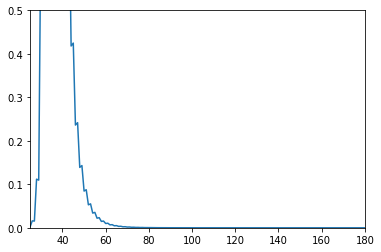

In [48]:
plt.plot(C[300, 300, :])
plt.axis([25, 180, 0, 0.5])